In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [8]:
import pickle
from os.path import join
from copy import copy
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import warnings
from collections import namedtuple
from itertools import product

from scipy.interpolate import RegularGridInterpolator
from scipy.stats import chi2, norm
from scipy.optimize import fmin_l_bfgs_b
import seaborn as sns

from settings import BASEPATH, ngc1068, txs0506
from tools import get_mids, array_source_interp
from aeff_calculations import get_energy_psf_grid, calc_aeff_factor, get_aeff_and_binnings
from fluxes import (
    atmo_background,
    astro_flux,
)



# Settings

In [9]:
matplotlib = sns.mpl
plt = matplotlib.pyplot
warnings.filterwarnings("ignore")
e_smearing_files = sorted(glob(join(BASEPATH, "resources/*energy_smearing_rgi.pckl")))
sigma5 = 1 - norm.cdf(5)
sigma3 = 1 - norm.cdf(3)
sigma1 = 1 - norm.cdf(1)

# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [11]:
aeff_2d_base, logE_bins_old, _, sindec_bins_old, _ = get_aeff_and_binnings("upgoing")
logE_mids = get_mids(logE_bins_old)
sindec_mids = get_mids(sindec_bins_old)

# provide interpolation function for effective area
aeff_interp = {}
pad_logE = np.concatenate([[logE_bins_old[0]], logE_mids, [logE_bins_old[-1]]])
pad_sd = np.concatenate([[-1], sindec_mids, [1]])
for k in aeff_2d_base:
    aeff_interp[k] = RegularGridInterpolator(
        (pad_logE, pad_sd),
        np.pad(np.log(aeff_2d_base[k]), 1, mode="edge"),
    )

# set up new finer binning
logE_bins = np.linspace(2, 9, num=81)
logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

sindec_bins = np.linspace(-1, 1, num=91)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")
# make a baseline evaluation of the interpolation
aeff_2d = {}
ss, ll = np.meshgrid(sindec_mids, logE_mids)
for k in aeff_2d_base:
    aeff_2d[k] = np.exp(aeff_interp[k]((ll, ss)))

80 log_10(energy) bins
90 declination bins


# Background

In [12]:
# MCEQ
with open(join(BASEPATH, "resources/MCEq_flux.pckl"), "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
# re-bin the atmospheric background flux
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["numu_conv"])
)
# baseline evaluation
ss, em = np.meshgrid(sindec_mids, emids)
spl_vals = np.exp(rgi((em, ss)))


# Energy resolution function

Plotting code can be found in `energy_resolution.ipynb`

In [13]:
# energy smearing matrix
with open(join(BASEPATH, "resources/energy_smearing_rgi.pckl"), "rb") as f:
    rgi = pickle.load(f)
# new binning
logE_reco_bins = np.arange(1.9, 9.05, step=0.05)
logE_reco_mids = get_mids(logE_reco_bins)
lge_grid, lre_grid = np.meshgrid(logE_mids, logE_reco_mids)
# baseline evaluation
baseline_nkv = rgi((lre_grid, lge_grid))

# normalize per bin in true energy
baseline_nkv = baseline_nkv / np.sum(baseline_nkv, axis=0)

# artificial, improved smearing matrix
with open(
    join(BASEPATH, "resources/improved_0.5_artificial_energy_smearing_rgi.pckl"), "rb"
) as f:
    rgi = pickle.load(f)
improved_nkv = rgi((lre_grid, lge_grid))
# normalize per bin in true energy
improved_nkv = improved_nkv / np.sum(improved_nkv, axis=0)


# PSF-Energy grid from the smearing matrix
$f_x(x) = kde(x)$ with $ x = \log_{10}(y) \Leftrightarrow y = 10^x$

Transform: $z = y² = 10^{(2\cdot x)}$ with $ x = \frac{\log_{10}(z)}{2} := g(z)$

$\Rightarrow f_z(z) = | \frac{d}{dz} g(z) | \cdot f(g(z)) = \frac{1}{2\cdot z \cdot \log(10)} kde(\frac{\log_{10}(z)}{2})$



Full 2D psi-energy LLH of sources around the horizon

NOTE: psi changes per detector over the day. Not yet implemented, effect probably negligible. We choose the horizontal resolution for all detectors

In [14]:
# psi² representation
delta_psi_max = 2
bins_per_psi2 = 25
all_grids, psi2_bins = get_energy_psf_grid(
    logE_mids, delta_psi_max=delta_psi_max, bins_per_psi2=bins_per_psi2
)
psi2_mids = get_mids(psi2_bins)

e_psi2_grid = all_grids['dec-0.0']
bckg_grid = np.ones_like(e_psi2_grid)
bckg_grid /= np.sum(bckg_grid, axis=0)

file exists: /home/lisajsch/repos/Plenum/resources/e_psf_grid_psimax-2_bins-25.pckl


# Flux definition

In [15]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}

## NGC1068 and TXS 0506+056 - source parameters

In [16]:
# livetime of 10yr PS data
lt_10yr = (376.4 + 352.6 + 316.0 + 332.9 + 2198.2) * 24 * 3600
lt_kde = LIVETIME = 3186 * 24 * 3600
# LIVETIME = 10 * 360 * 24 * 3600 # 360 days of data taking per year

# 10yr PS PAPER PARAMETERS of NGC 1068
GAMMA_NGC = 3.2
PHI_NGC = 5E-14 # @ 1 TeV / GeV cm² s
E0_NGC = 1E3

# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(BASEPATH, "resources/ngc_paper_68_contour.txt"))
phi_c_68 /= 1E11
#gamma_c_68, phi_c_68 = np.loadtxt("../resources/tenyr_paper_68_contour.txt")


# TXS parameters
with open(join(BASEPATH, "resources/txs_contour.pkl"), "rb") as f:
    txs_contour = pickle.load(f)

GAMMA_TXS = 2. #txs_contour["best-fit"][0]
PHI_TXS = 2.7E-20 #txs_contour["best-fit"][1] / 1E3 / 3 # fudge factor. # @ 1 TeV / GeV cm² s
E0_TXS = txs_contour["E0"] 

ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")
txs_flux = PL_flux(PHI_TXS, GAMMA_TXS, E0_TXS, "powerlaw")


In [17]:
# analysis region in distance to source
delta_psi_max = 2

# generic source config without dec coordinate
src_config = dict(
    sindec_mids=sindec_mids,
    livetime=LIVETIME,
    ewidth=ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = delta_psi_max
bg_config["grid_2d"] = bckg_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = ngc1068.dec.rad

# ... with txs declination
txs_src_config = copy(src_config)
txs_src_config["dec"] = txs0506.dec.rad
txs_bg_config = copy(bg_config)
txs_bg_config["dec"] = txs0506.dec.rad


## Check event numbers

In [18]:
ident = "IceCube"
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
k_s = astro_flux(
    aeff_factor_signal,
    emids,
    normed_kvals=baseline_nkv,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~80

## check event numbers
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **txs_src_config)
k_s = astro_flux(
    aeff_factor_signal,
    emids,
    normed_kvals=baseline_nkv,
    phi_scaling=1,
    flux_shape=txs_flux,
)
print("txs 0506+056:", np.sum(k_s))  # ~5


ngc 1068: 83.57040461805781
txs 0506+056: 4.859902091824563


# Set up LLH function

In [21]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    shape,
    normed_kvals,
    verbose=False,
):
    """fit parameters in x:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2:]: other signal parameters
        see 'astro_flux' for further shapes and parameters

    mu_b_base: background baseline
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_0: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape
    """
    mu_b = mu_b_base * x[0]
    mu_s = astro_flux(
        mu_s_base,
        emids,
        normed_kvals,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    if verbose:
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))
    mu_i = mu_s + mu_b

    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


# Loop through parameters and check fit results

In [46]:
# cutoff parameters
Gamma_cuts = np.linspace(1.5, 2.5, num=20)
logE_cuts = np.linspace(3, 4, num=15) # log10 (Ecut / GeV)
pvals_ngc = []
identifier = "Plenum-1"

for Gamma_cut, logE_cut in product(Gamma_cuts, logE_cuts):
    tmp_flux = PLcut_flux(
        PHI_NGC, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff"
    )

    ### scale the fluxes such that the event numbers match
    aeff_factor_signal = calc_aeff_factor(aeff_2d[identifier], **ngc_src_config)
    astro_ev_sum_pl = np.sum(
        astro_flux(
            aeff_factor_signal,
            emids,
            baseline_nkv,
            1,
            ngc_flux,
        )
    )

    # cutoff
    astro_ev_sum_cut = np.sum(
        astro_flux(
            aeff_factor_signal,
            emids,
            baseline_nkv,
            1,
            tmp_flux,
        )
    )
    flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut

    # define the correctly normalized PL+cut flux for NGC 1068
    ngc_cut_flux = PLcut_flux(
        PHI_NGC * flux_scaling_cut, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff"
    )

    aeff_factor_bckg = calc_aeff_factor(aeff_2d[identifier], **ngc_bg_config)
    aeff_factor_signal = calc_aeff_factor(aeff_2d[identifier], **ngc_src_config)
    ## add the other detector configs to IceCube
    if identifier != "IceCube":
        aeff_factor_bckg += calc_aeff_factor(aeff_2d["IceCube"], **ngc_bg_config)
        aeff_factor_signal += calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)

    for nkv, es_ident in zip([baseline_nkv, improved_nkv], ["baseline", "improved"]):

        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(ngc_src_config["dec"], spl_vals, sindec_mids),
            normed_kvals=nkv,
        )
        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            nkv,
            1,
            ngc_cut_flux,  # powerlaw with cutoff
        )
        k_i = k_s + k_b

        dct = dict(
            mu_b_base=k_b,
            mu_s_base=aeff_factor_signal,
            k_i=k_i,
            e_0=ngc_flux.E0,
            phi_0=ngc_flux.norm,
            normed_kvals=nkv,
        )
        pl_func = lambda x: ps_llh_2d_composite(x, shape="powerlaw", **dct)
        out_bckg = fmin_l_bfgs_b(
            pl_func,
            x0=(1.2, 1.2, 3.0),
            approx_grad=True,
        )
        print("bckg params:", out_bckg[0])

        comp = lambda x: ps_llh_2d_composite(x, shape="powerlaw with cutoff", **dct)
        out_comp = fmin_l_bfgs_b(
            comp,
            x0=(1.2, 1.1, 1.9, 3.4),
            approx_grad=True,
        )
        print("global params:", out_comp[0])
        print("true params:", (1, flux_scaling_cut, Gamma_cut, logE_cut))

        # check the LLH at the "correct" parameter position
        check = comp((1, flux_scaling_cut, Gamma_cut, logE_cut))
        pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
        pval_check = chi2.sf(out_bckg[1] - check, 1)
        significance = norm.isf(pval)
        print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
        print("pval check:", pval_check, "ratio:", pval_check / pval)
        print("")
        pvals_ngc.append(
            {
                "identifier": identifier,
                "e_smearing": es_ident,
                "pval": pval,
                "pval_check": pval_check,
                "significance": significance,
                "gamma_cut": Gamma_cut,
                "logE_cut": logE_cut,
                "flux_scaling": flux_scaling_cut,
                "out_pl_gamma": out_bckg[0][2],
                "out_pl_norm": out_bckg[0][1],
                "out_plc_gamma": out_comp[0][2],
                "out_plc_norm": out_comp[0][1],
            }
        )
pvals_ngc = pd.DataFrame(pvals_ngc)


bckg params: [0.99251032 1.04950852 3.34627971]
global params: [0.99849221 2.39933071 2.25800765 3.29955831]
true params: (1, 4.643178009232849, 1.5, 3.0)
P-VALUE: 0.17290644922271428 SIGNIFICANCE: 0.9427419735233898
pval check: 0.16655995255376232 ratio: 0.9632951998176928

bckg params: [1.00145185 0.99999869 3.28964683]
global params: [0.99999276 4.63621102 1.50126763 3.00057194]
true params: (1, 4.643178009232849, 1.5, 3.0)
P-VALUE: 0.0002685499612693493 SIGNIFICANCE: 3.4615371819671616
pval check: 0.00026854790294212006 ratio: 0.9999923354029935

bckg params: [0.99100226 1.06558866 3.29122834]
global params: [0.99839758 2.15778383 2.20509583 3.3543676 ]
true params: (1, 3.656657264009956, 1.5, 3.0714285714285716)
P-VALUE: 0.14352937553295833 SIGNIFICANCE: 1.0645960875972
pval check: 0.13837019134180167 ratio: 0.9640548551681536

bckg params: [0.99961327 1.01293467 3.23766885]
global params: [1.00013034 3.65384767 1.49886778 3.07140223]
true params: (1, 3.656657264009956, 1.5, 3.071

Text(0.5, 1.0, 'Close to $\\gamma$=-3.2')

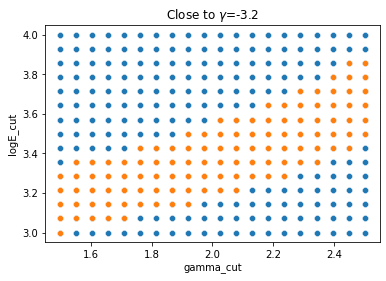

In [62]:
sns.scatterplot(data=pvals_ngc, x="gamma_cut", y="logE_cut")
ax = sns.scatterplot(data=pvals_ngc.loc[np.isclose(pvals_ngc.out_pl_gamma, GAMMA_NGC, atol=0.1)], x="gamma_cut", y="logE_cut")
ax.set_title(fr"Close to $\gamma$=-{GAMMA_NGC}")

In [63]:
pvals_ngc["gamma_diff"] = pvals_ngc.out_pl_gamma - GAMMA_NGC

Text(0.5, 1.0, 'Close to $\\gamma$=-3.2')

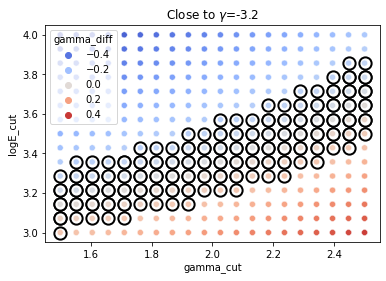

In [87]:
plt.scatter(
    pvals_ngc.loc[np.isclose(pvals_ngc.out_pl_gamma, GAMMA_NGC, atol=0.1)].gamma_cut,
    pvals_ngc.loc[np.isclose(pvals_ngc.out_pl_gamma, GAMMA_NGC, atol=0.1)].logE_cut,
    color="w",
    s=150,
    linewidth=2,
    edgecolors="k",
)
ax = sns.scatterplot(data=pvals_ngc, x="gamma_cut", y="logE_cut", hue="gamma_diff", palette="coolwarm")
ax.set_title(fr"Close to $\gamma$=-{GAMMA_NGC}")